0. Set Up

In [1]:

!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

Cloning into 'Demeter_metamorphosis'...
remote: Enumerating objects: 5907, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 5907 (delta 300), reused 328 (delta 198), pack-reused 5441 (from 1)
Receiving objects: 100% (5907/5907), 631.00 MiB | 49.09 MiB/s, done.
Resolving deltas: 100% (3868/3868), done.
Updating files: 100% (178/178), done.


Install packages, (needs to be executed twice because of a bug in pip. exucute, restart the kernel and re-execute this cell)

In [1]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

!pip install pynrrd
!pip install -U ipywidgets
print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11-0.editable-py3-none-any.whl size=4322 sha256=009a21e5e86cb8f691d7edb3299d9b02e31b980def99f7faad2255b019c26171
  Stored in directory: /tmp/pip-ephem-wheel-cache-g9l8kg9h/wheels/b0/6a/69/c66c8a74253f8baa35c990caf2c48f3d36ded6d5a7d58f0e62
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.11
    Uninstalling demeter_metamorphosis-0.2.11:
      Successfully uninstalled demeter_metamorphosis-0.2.11
['/content/Demeter_metamorphosis', 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

## 0.2 After jupyter restart, run:

In [ ]:
# %matplotlib widget

import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



# 1. Code utile

In [3]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.cuda import OutOfMemoryError, device

import demeter.utils.torchbox as tb
import demeter.utils.axes3dsliders_plt as a3s
import demeter.utils.rigid_exploration as rg
## Faire Recalage Rigid + Meta
import demeter.utils.reproducing_kernels as rk
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2
import demeter.metamorphosis as mt
import demeter.metamorphosis.rotate as mtrt

def to_torch(img):
    return torch.from_numpy(img)[None, None]

def normalize(img):
    quant = np.quantile(img, 0.99)
    print(quant, img.max())
    img = np.clip(img, 0,quant)
    img /= img.max()
    return img

import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()

/usr/local/lib/python3.12/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/content/Demeter_metamorphosis/src/demeter/utils/toolbox.py:286: SyntaxWarning: invalid escape sequence '\d'
  print(f'convert -delay {delay} -loop 0 {folder}/{file_name}_\d{3}.png {folder}/{file_name}.gif')
/content/Demeter_metamorphosis/src/demeter/utils/vector_field_to_flow.py:220: SyntaxWarning: invalid escape sequence '\i'
  tb.deformation_show(integrated[t_i].unsqueeze(0),step=step,title='$\int_0^'+str(t_i)+'v(t) dt$')


🔍 Vérification de l'environnement Matplotlib interactif...
❌ ipympl (nécessaire pour `%matplotlib widget`) n'est pas installé.
👉 Exécute : `pip install ipympl` dans une cellule ou un terminal.
saves_overview.csv


/content/Demeter_metamorphosis/src/demeter/metamorphosis/data_cost.py:421: SyntaxWarning: invalid escape sequence '\c'
  D(I,T) =  alpha *| I_1 \cdot A.T  - T |^2 + (1 - alpha) * | S \cdot A.T - T|^2


## Open images

In [ ]:
# # Open template
# if "content" in cwd:
#   template_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
#   ixi_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
# else:
#   template_folder ="/home/turtlefox/Documents/11_metamorphoses/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
#   ixi_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI-T1_fastsurfer/IXI002/mri/"
#
# template_name = "mni_icbm152_t1_tal_nlin_asym_09c.nii"
# template_mask_name = "mni_icbm152_t1_tal_nlin_asym_09c_mask.nii"
#
# template = nib.load(os.path.join(template_folder, template_name)).get_fdata()
# template_mask = nib.load(os.path.join(template_folder, template_mask_name)).get_fdata()
# template[template_mask == 0] = 0
#
#
# print("template :",template.shape)
#
# # Open ixi image
#
# # ixi_list = os.listdir(ixi_folder)
# ixi_image_name = "orig_nu.mgz"
# # ixi_image_name = "firt_toMNI_orig_nu.nii.gz"
# ixi_segs_name = "aseg.auto_noCCseg.mgz"
# ixi_mask_name = "mask.mgz"
# # ixi_mask_name = "firt_toMNI_orig_nu_mask.nii.gz"
#
# ixi_img = nib.load(os.path.join(ixi_folder, ixi_image_name)).get_fdata()
# ixi_segs = nib.load(os.path.join(ixi_folder, ixi_segs_name)).get_fdata()
# ixi_mask = nib.load(os.path.join(ixi_folder, ixi_mask_name)).get_fdata()
# ixi_img[ixi_mask == 0] = 0
#
# print("ixi_img :",ixi_img.shape)
# print("ixi_segs :",ixi_segs.shape)
# name = "IXI002_to_template"
#
#
# # Normalise images to [0,1]
# template = normalize(template)
# ixi_img = normalize(ixi_img)
#
# #  Resize ixi image
# template = to_torch(template)
# template = tb.resize_image(template, scale_factor= .5)
# ixi_img = to_torch(ixi_img)
# ixi_img = tb.resize_image(ixi_img, to_shape=template.shape[2:])
#
# print(ixi_img.shape)
#
# img = ixi_img[0,0,..., ixi_img.shape[-1]//2].detach().cpu()
# img_target = tb.imCmp(ixi_img[..., ixi_img.shape[-1]//2].detach().cpu(), template[..., ixi_img.shape[-1]//2].detach().cpu(), "compose")[0]
# img_source = template[..., ixi_img.shape[-1]//2].detach().cpu()[0,0]
# fig,ax = plt.subplots(1,3)
# ax[0].imshow(img, cmap="gray")
# ax[0].set_title("image")
# ax[1].imshow(img_target, cmap="gray")
# ax[1].set_title("img vs target")
# ax[2].imshow(img_source, cmap="gray")
# ax[2].set_title("img vs source")
# plt.show()
#
# print(img.dtype)

Template shape: (193, 229, 193)
Template affine:
 [[   1.    0.    0.  -96.]
 [   0.    1.    0. -132.]
 [   0.    0.    1.  -78.]
 [   0.    0.    0.    1.]]
IXI image shape: (192, 256, 256)
IXI image affine:
 [[   0.9375        0.            0.          -87.70262146]
 [   0.            0.9375        0.         -106.82574463]
 [   0.            0.            0.9375      -98.23861694]
 [   0.            0.            0.            1.        ]]
IXI segs unique:  [ 0.  2.  3.  4.  5.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18. 24. 26.
 28. 31. 41. 42. 43. 44. 46. 47. 49. 50. 51. 52. 53. 54. 58. 60. 63. 77.]
ixi_to_tpl_segs unique : [ 0.  2.  3.  4.  5.  7.  8. 10. 11. 12. 13. 14. 15. 16. 17. 18. 24. 26.
 28. 31. 41. 42. 43. 44. 46. 47. 49. 50. 51. 52. 53. 54. 58. 60. 63. 77.]


(192, 256)


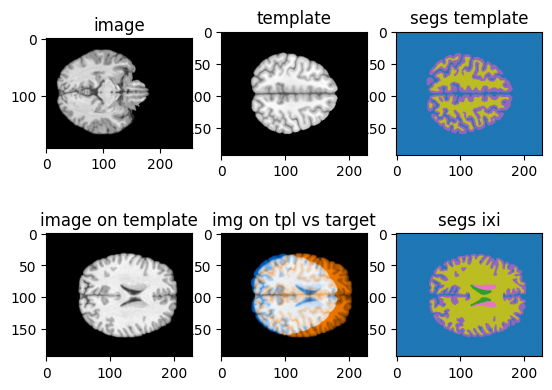

109.61312103271487 tensor(146.5965, dtype=torch.float64)
89.21373212197796 tensor(97.6631, dtype=torch.float64)
<class 'torch.Tensor'>
tensor([0., 1., 2., 3., 4., 5.], dtype=torch.float64) tensor([0., 1., 2., 3., 4., 5.], dtype=torch.float64)
Dice before reg : 0.13985129802702487


In [4]:
import os
import nibabel as nib
import numpy as np
from nibabel.processing import resample_from_to

# ---------- user paths ----------
if "content" in cwd:
  template_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
  ixi_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
  template_seg_path = ""
else:
  template_folder ="/home/turtlefox/Documents/11_metamorphoses/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
  ixi_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI-T1_fastsurfer/IXI002-Guys-0828-T1/mri/"
  template_seg_path = "fastsurfer/mri/"

# out_folder = "/path/to/out"
# os.makedirs(out_folder, exist_ok=True)

template_name = "mni_icbm152_t1_tal_nlin_asym_09c.nii"
template_mask_name = "mni_icbm152_t1_tal_nlin_asym_09c_mask.nii"
template_segs_name = "mni_icbm152.auto_noCCseg.mgz"

ixi_image_name = "orig_nu.mgz"               # intensity image
ixi_segs_name = "aseg.auto_noCCseg.mgz"      # discrete labels
ixi_mask_name = "mask.mgz"                   # brain mask
name = "IXI002_to_template"

def load_canonical(img_path: str) -> nib.spatialimages.SpatialImage:
    """Load image and convert to RAS+ canonical orientation (safer for affine math)."""
    img = nib.load(img_path)
    return nib.as_closest_canonical(img)


def save_like(target_img: nib.spatialimages.SpatialImage, new_data: np.ndarray, out_path: str, dtype=np.float32):
    """Save `new_data` in the same space/affine/header class as target_img."""
    new_img = target_img.__class__(new_data.astype(dtype), target_img.affine, target_img.header)
    nib.save(new_img, out_path)
    return out_path

def simplify_segs(seg):
    # Create new label map (e.g. 0-5)
    new_seg = np.zeros_like(seg)

    # Define label sets
    CSF = [4, 43, 15, 14]
    GM = [3, 42, *range(1000, 1036), *range(2000, 2036)]
    WM = [2, 41, 77]
    SCGM = [10, 11, 12, 13, 17, 18, 26, 49, 50, 51, 52, 53, 54, 58]
    BRAINSTEM = [16]

    # Map new labels
    # plt.imshow(np.isin(seg,GM))
    new_seg[np.isin(seg, CSF)] = 1
    new_seg[np.isin(seg, GM)] = 2
    new_seg[np.isin(seg, SCGM)] = 3
    new_seg[np.isin(seg, WM)] = 4
    new_seg[np.isin(seg, BRAINSTEM)] = 5

    return new_seg

# ---------- load template & mask (canonical) ----------
tpl_img = load_canonical(os.path.join(template_folder, template_name))
tpl_msk_img = load_canonical(os.path.join(template_folder, template_mask_name))
tpl_segs_img = load_canonical(os.path.join(template_folder, template_seg_path, template_segs_name))

# Zero template outside its mask (optional)
tpl_data = tpl_img.get_fdata()
tpl_msk = tpl_msk_img.get_fdata() > 0.5
tpl_data_masked = np.where(tpl_msk, tpl_data, 0.0)
# save_like(tpl_img, tpl_data_masked, os.path.join(out_folder, "template_masked.nii.gz"))

print("Template shape:", tpl_img.shape)
print("Template affine:\n", tpl_img.affine)

# ---------- load IXI data (canonical) ----------
ixi_img = load_canonical(os.path.join(ixi_folder, ixi_image_name))
ixi_segs = load_canonical(os.path.join(ixi_folder, ixi_segs_name))
ixi_mask = load_canonical(os.path.join(ixi_folder, ixi_mask_name))

print("IXI image shape:", ixi_img.shape)
print("IXI image affine:\n", ixi_img.affine)
print("IXI segs unique: ", np.unique( ixi_segs.get_fdata()))

# ---------- optional: mask IXI intensities in native space ----------
ixi_img_data = ixi_img.get_fdata()
ixi_mask_data = ixi_mask.get_fdata() > 0.5
ixi_img_data = np.where(ixi_mask_data, ixi_img_data, 0.0)
ixi_img_masked = ixi_img.__class__(ixi_img_data.astype(np.float32), ixi_img.affine, ixi_img.header)

# ---------- define the target space (template grid + affine) ----------
target_spec = (tpl_img.shape, tpl_img.affine)

# ---------- resample to template space ----------
# Intensities: cubic (order=3)
ixi_to_tpl_img = resample_from_to(ixi_img_masked, target_spec, order=3)

# Labels: nearest (order=0) to preserve integers
ixi_to_tpl_segs = resample_from_to(ixi_segs, target_spec, order=0)
print('ixi_to_tpl_segs unique :', np.unique(ixi_segs.get_fdata()))

# Mask: nearest
ixi_to_tpl_mask = resample_from_to(ixi_mask, target_spec, order=0)

# ---------- simplify segmentations -------
tpl_segs_data = simplify_segs(tpl_segs_img.get_fdata())
ixi_segs_data = simplify_segs(ixi_to_tpl_segs.get_fdata())


# ---------- re-mask intensities after resampling (optional but common) ----------
tpl_mask_resampled = ixi_to_tpl_mask.get_fdata() > 0.5
ixi_to_tpl_img_data = ixi_to_tpl_img.get_fdata()
ixi_to_tpl_img_data = np.where(tpl_mask_resampled, ixi_to_tpl_img_data, 0.0)

# ---------- save results ----------
# out_img = os.path.join(out_folder, "ixi_in_mni09c_orig_nu.nii.gz")
# out_segs = os.path.join(out_folder, "ixi_in_mni09c_aseg.nii.gz")
# out_mask = os.path.join(out_folder, "ixi_in_mni09c_mask.nii.gz")
#
# save_like(tpl_img, ixi_to_tpl_img_data, out_img)
# save_like(tpl_img, ixi_to_tpl_segs.get_fdata(), out_segs, dtype=np.int16)
# save_like(tpl_img, tpl_mask_resampled.astype(np.uint8), out_mask, dtype=np.uint8)
#
# print("Saved:")
# print(" -", out_img)
# print(" -", out_segs)
# print(" -", out_mask)

# ---------- figure ---------
def tt(ndaray):
    return torch.tensor(ndaray)[None, None] / ndaray.max()


slice_boom = ixi_img.shape[-1]//2
img = ixi_img_data[..., slice_boom]
# img_target = tb.imCmp(
#     tt(ixi_img_data[..., slice_boom]),
#     tt(tpl_data[..., slice_boom]),
#     "compose")[0]
img_target =  tpl_data_masked[..., slice_boom]
segs_tp = ixi_segs_data[..., slice_boom]
segs_tpl_tp = tpl_segs_data[..., slice_boom]

img_tpl = ixi_to_tpl_img_data[..., slice_boom]
img_target_tpl = tb.imCmp(
    tt(ixi_to_tpl_img_data[..., slice_boom]),
    tt(tpl_data_masked[..., slice_boom]),
    "compose")[0]

print(img.shape)

fig,ax = plt.subplots(2,3)
ax[0,0].imshow(img, cmap="gray")
ax[0,0].set_title("image")
ax[0,1].imshow(img_target, cmap="gray")
ax[0,1].set_title("template")
ax[0,2].imshow(segs_tpl_tp, cmap="tab20", vmin= tpl_segs_data.min(), vmax= tpl_segs_data.max())
ax[0,2].set_title("segs template")

ax[1,0].imshow(img_tpl, cmap="gray")
ax[1,0].set_title("image on template")
ax[1,1].imshow(img_target_tpl, cmap="gray")
ax[1,1].set_title("img on tpl vs target")
ax[1,2].imshow(segs_tp, cmap="tab20", vmin=ixi_segs_data.min(), vmax= ixi_segs_data.max())
ax[1,2].set_title("segs ixi")

plt.show()


source = normalize(to_torch(ixi_to_tpl_img_data))
target = normalize(to_torch(tpl_data_masked))
seg_source = to_torch(ixi_segs_data)
seg_target = to_torch(tpl_segs_data)

resize_factor = .7
if resize_factor != 1:
    source = tb.resize_image(source, scale_factor=resize_factor)
    target = tb.resize_image(target, scale_factor=resize_factor)
    seg_source = tb.resize_image(
        seg_source,
        scale_factor=resize_factor,
        mode = 'nearest'
    )
    seg_target = tb.resize_image(
        seg_target,
        scale_factor=resize_factor,
        mode = 'nearest'
    )

starting_dice = tb.average_dice(seg_source, seg_target)
print(f"Dice before reg : {starting_dice}")


## Recherche rigide


In [5]:
# Recherche rigide
source_b, target_b, trans_s, trans_t = rg.align_barycentres(source, target, verbose=True)

S compute barycentre : tensor([0.1950, 0.0476, 0.0126], dtype=torch.float64)
T compute barycentre : tensor([-0.0858, -0.0352, -0.0024], dtype=torch.float64)
diff :  tensor([-0.2808, -0.0828, -0.0150], dtype=torch.float64)


In [ ]:
kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
# datacost = mt.Rotation_MutualInformation_Cost(target_b.to('cuda:0'), alpha=1)


mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)
top_params = rg.initial_exploration(mr,r_step=10, max_output = 15, verbose=True)
print(top_params)

In [ ]:
best_loss, best_momentum_R, best_momentum_T, best_momentum_S, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)


In [6]:
best_momentum_R = torch. tensor([[-0.0418, -0.1997,  0.0224],
        [ 0.1988, -0.0414,  0.0215],
        [-0.0291, -0.0109, -0.0010]])
best_momentum_T = torch. tensor([-0.0040, -0.0030,  0.0015])
best_momentum_S = torch. tensor([0.1479, 0.0832, 0.0471])
best_rotation = torch.tensor([[-0.3807,  0.9247, -0.0035],
        [-0.9247, -0.3807,  0.0040],
        [ 0.0024,  0.0048,  1.0000]])

## Check rigid search

tensor([[-0.0418, -0.1997,  0.0224],
        [ 0.1988, -0.0414,  0.0215],
        [-0.0291, -0.0109, -0.0010]], requires_grad=True)
tensor([-0.0040, -0.0030,  0.0015], requires_grad=True)
[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 22.25 MB | Max Reserved: 24.00 MB


/content/Demeter_metamorphosis/src/demeter/metamorphosis/rotate.py:295: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  momT_translated = momentum_T @ translation.T


<class 'torch.Tensor'>
tensor([0., 1., 2., 3., 4., 5.], grad_fn=<Unique2Backward0>) tensor([0., 1., 2., 3., 4., 5.], dtype=torch.float64)
	dice for value 1.0 is 0.010792249202845229
	dice for value 2.0 is 0.23081958080913587
	dice for value 3.0 is 0.06027385663795475
	dice for value 4.0 is 0.32732506216803614
	dice for value 5.0 is 0.20692933347417344
	average dice is 0.16722801645842905
Rigid dice : 0.16722801645842905
<class 'torch.Tensor'>
tensor([0., 1., 2., 3., 4., 5.], grad_fn=<Unique2Backward0>) tensor([0., 1., 2., 3., 4., 5.], dtype=torch.float64)
	dice for value 1.0 is 0.010792249202845229
	dice for value 2.0 is 0.23081958080913587
	dice for value 3.0 is 0.06027385663795475
	dice for value 4.0 is 0.32732506216803614
	dice for value 5.0 is 0.20692933347417344
	average dice is 0.16722801645842905
rigid_dice: tensor(0.1672, dtype=torch.float64)
reg_dice: tensor(0.1672, dtype=torch.float64)


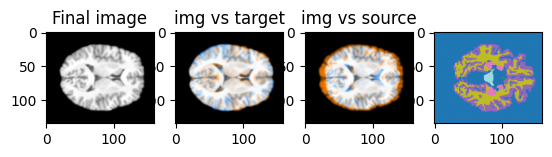

In [7]:
momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    source_b.shape,
    image=False,
    rotation=True,
    translation=True,
    scaling=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),# - trans_s + trans_t,
    scale_prior=best_momentum_S,
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source_b.cpu(), momenta, save=True)

(rigid_dice, reg_dice), (rotated_source_segs, deformed_source_segs) = mr.compute_DICE(seg_source, seg_target)
print("rigid_dice:", rigid_dice)
print("reg_dice:", reg_dice)

# a3s.Visualize_GeodesicOptim_plt(mr, "random")
rot_def = tb.grid_from_rotation_translation(mr.mp.id_grid, mr.mp.rot_mat, mr.mp.translation)
rot_def =   tb.grid_from_rotation(mr.mp.id_grid, mr.mp.rot_mat.T)
rot_def += mr.mp.translation
rot_def = mr.mp.get_rigidor()
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')
img = rotated_source[0,0,..., mr.source.shape[-1]//2].detach().cpu()

img_target = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.target[..., source.shape[-1]//2].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[..., source.shape[-1]//2].detach().cpu(), mr.source[..., source.shape[-1]//2].detach().cpu(), "compose")[0]

fig,ax = plt.subplots(1,4)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")
ax[3].imshow(rotated_source_segs.detach()[0,0, ..., source.shape[-1]//2], cmap="tab20")

plt.show()

## LDDMM

True
True
True
True
momenta type <class 'dict'>


/content/Demeter_metamorphosis/src/demeter/utils/fft_conv.py:114: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  output = output[crop_slices].contiguous()


Progress: [#---------]  13.33%  (Rotation_Ssd_Cost : ,22506.5703).
Progress: [##--------]  20.00%  (Rotation_Ssd_Cost : ,20997.7148).
Progress: [###-------]  26.67%  (Rotation_Ssd_Cost : ,20362.1230).
Progress: [###-------]  33.33%  (Rotation_Ssd_Cost : ,19959.5410).
Progress: [####------]  40.00%  (Rotation_Ssd_Cost : ,19671.9160).
Progress: [#####-----]  46.67%  (Rotation_Ssd_Cost : ,19416.0137).
Progress: [#####-----]  53.33%  (Rotation_Ssd_Cost : ,19234.8789).
Progress: [######----]  60.00%  (Rotation_Ssd_Cost : ,19035.6055).
Progress: [#######---]  66.67%  (Rotation_Ssd_Cost : ,18896.3184).
Progress: [#######---]  73.33%  (Rotation_Ssd_Cost : ,18752.1270).
Progress: [########--]  80.00%  (Rotation_Ssd_Cost : ,18618.4336).
Progress: [#########-]  86.67%  (Rotation_Ssd_Cost : ,18495.4316).
Progress: [#########-]  93.33%  (Rotation_Ssd_Cost : ,18393.5820).
Progress: [##########] 100.00% Done...
 (Rotation_Ssd_Cost : ,18274.5664).

Computation of forward done in  0:02:30s and 0.098cen

(<Figure size 1000x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Lambda = 1e-06'}>, <Axes: >], dtype=object))

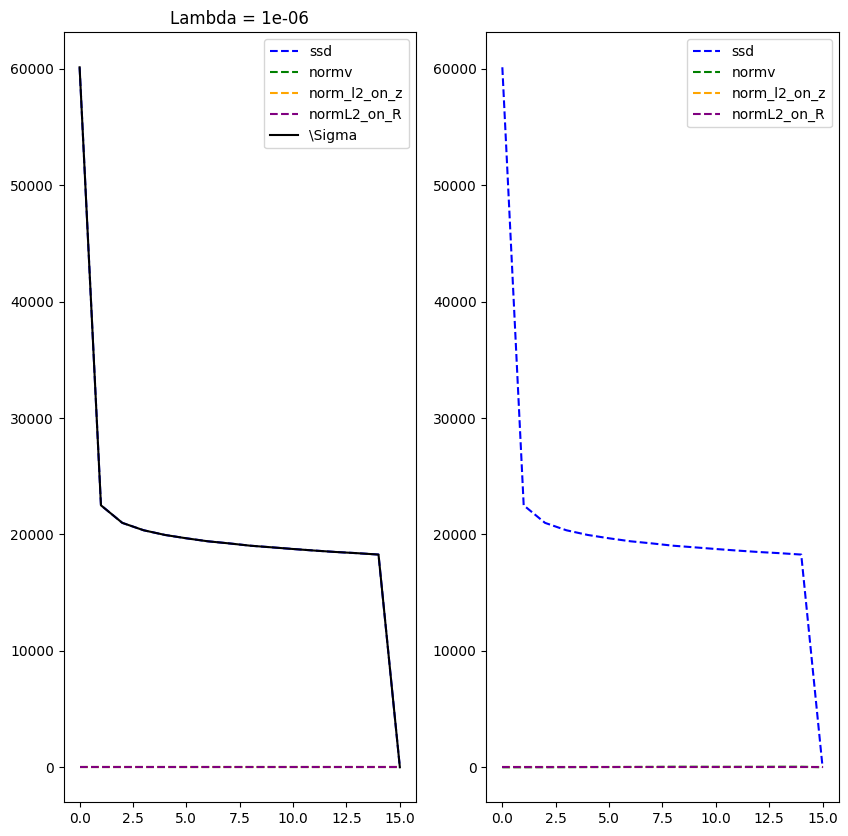

In [8]:

sigma= [3, 5, 7]
sigma = [(s,)*3 for s in sigma]
kernelOperator = rk.Multi_scale_GaussianRKHS(sigma, normalized=False)

datacost = mt.Rotation_Ssd_Cost(target_b.to("cuda:0"), alpha=.3)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)

momenta = mtrt.prepare_momenta(
    mr.source.shape,
    # ixi_img.shape,
    image=True,
    rotation=True,
    translation=True,
    scaling=True,
    # rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),
)

for v in momenta.values():
    print(v.requires_grad)
rho = 1
try:
  mr = mt.rigid_along_metamorphosis(
      source_b, target_b, momenta_ini=momenta,
      kernelOperator= kernelOperator,
      rho = rho,
      data_term=datacost ,
      integration_steps = 10,
      cost_cst=1e-6,
      n_iter=15,
      save_gpu_memory=False,
      lbfgs_max_iter = 20,
      lbfgs_history_size = 20,
  )
except OutOfMemoryError:
  print("GPU out Out of memory! ")
  torch.cuda.empty_cache()

mr.compute_DICE(seg_source, seg_target)
mr.plot_cost()


residual min -0.0 max -0.0


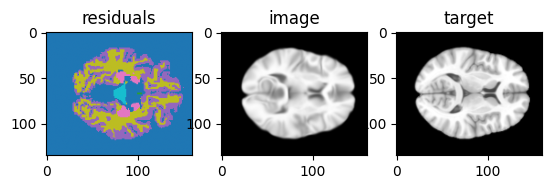

In [9]:
# fig, ax = plt.subplots(1,3)
T, _, D, H, W = source.shape
print(f"residual min {mr.mp.residuals.min()} max {mr.mp.residuals.max()}")
# Choose a central slice for plotting
slice_index = W // 2
fig, ax = plt.subplots(1,3)
ax[0].imshow(deformed_source_segs[0,0,..., slice_index].detach().cpu(), cmap='tab10')
ax[0].set_title(f'residuals')
ax[1].imshow(mr.mp.image[0,0,..., slice_index].cpu(), cmap='gray')
ax[1].set_title(f'image')

ax[2].imshow(mr.target[0,0,..., slice_index], cmap='gray')
ax[2].set_title(f'target')
plt.show()

In [ ]:
name = "IXI002_to_template"
a3s.Visualize_GeodesicOptim_plt(mr, f"{name}_metaRigid_rho{rho}")


In [11]:
name = "IXI002_to_template"
mr.save(f"{name}_ixibrain_rigidscalingLDDMM_colab",save_path="/content/drive/MyDrive/demeter_data/demeter_optim/")


ic| abstract.py:1569 in save()
    path: '/content/drive/MyDrive/demeter_data/demeter_optim/'



BUG WARNING : An other data term than Ssd was detectedFor now our method can't save it, it is ok to visualisethe optimisation, but be careful loading the optimisation.

Optimisation saved in /content/drive/MyDrive/demeter_data/demeter_optim/3D_20250829_IXI002_to_template_ixibrain_rigidscalingLDDMM_colab_root_002.pk1 



('3D_20250829_IXI002_to_template_ixibrain_rigidscalingLDDMM_colab_root_002.pk1',
 '/content/drive/MyDrive/demeter_data/demeter_optim/')